# Predicting land prices in BsAs, Argentina

In [1]:
# Import the necessary packages
import numpy as np # Library to handle data in a vectorized manner
import pandas as pd # Library for data analysis
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # Module to convert an address into latitude and longitude values
import requests # Library we use to open URLs
# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map rendering library
# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [2]:
# Import dataframe
df = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/terrenos-valor-de-oferta/precio-de-terrenos-2018.csv')
df.head()

,operacion,tipo,long,lat,m2total,direccion,calle,altura,cambio,preciotex,preciousd,precioars,preciousdm,precioarsm,barrio,comuna,codigo_postal,codigo_postal_argentino
0,VTA,TERRENO,-58.414071,-34.618214,320.0,Agrelo 3399,Agrelo,3399.0,37.2,U$S 330000,330000.0,12276000.0,1031.250000,38362.500000,ALMAGRO,5.0,1224.0,C1224ABE
1,VTA,TERRENO,-58.424566,-34.610097,320.0,Bartolome Mitre y Gascon,Bartolome Mitre y Gascon,NaN,37.2,U$S 690000,690000.0,25668000.0,2156.250000,80212.500000,ALMAGRO,5.0,NaN,NaN
2,VTA,TERRENO,-58.424486,-34.613659,174.0,Don Bosco,Don Bosco,NaN,37.2,U$S 380000,380000.0,14136000.0,2183.908046,81241.379310,ALMAGRO,5.0,NaN,NaN
3,VTA,TERRENO,-58.423651,-34.614752,650.0,Hipolito Irigoyen 4043,Hipolito Irigoyen,4043.0,37.2,U$S 1000000,1000000.0,37200000.0,1538.461538,57230.769231,ALMAGRO,5.0,NaN,NaN
4,VTA,TERRENO,-58.413725,-34.603124,283.0,HUMAHUACA 3400,HUMAHUACA,3400.0,37.2,U$S 850000,850000.0,31620000.0,3003.533569,111731.448763,ALMAGRO,5.0,1191.0,C1191ABB


In [3]:
# Shape of dataframe
df.shape

(902, 18)

In [4]:
df.describe()

,long,lat,m2total,altura,cambio,preciousd,precioars,preciousdm,precioarsm,comuna,codigo_postal
count,902.000000,902.000000,902.000000,812.000000,902.000000,9.020000e+02,9.020000e+02,902.000000,902.000000,902.000000,735.000000
mean,-58.457901,-34.601354,463.399889,2338.922414,37.043902,9.498117e+05,3.531288e+07,2460.704583,91423.598577,9.004435,1352.881633
std,0.247139,0.206322,636.105738,1726.036245,2.224748,1.117378e+06,4.158228e+07,1878.327054,69678.379201,4.290503,113.720849
min,-65.779544,-34.689147,0.000000,0.000000,0.000000,7.950000e+02,3.013000e+04,3.935644,149.158416,0.000000,1008.000000
25%,-58.480144,-34.629569,202.000000,900.000000,36.400000,3.700000e+05,1.364400e+07,1274.312897,47381.760340,5.000000,1262.000000
50%,-58.453025,-34.610196,311.000000,2000.000000,37.200000,6.500000e+05,2.410200e+07,1958.378840,73206.666992,10.000000,1414.000000
75%,-58.420598,-34.589735,466.000000,3400.000000,37.900000,1.050000e+06,3.885000e+07,2976.523756,111460.084033,13.000000,1426.000000
max,-58.359279,-28.469581,9969.000000,10600.000000,37.900000,9.000000e+06,3.335200e+08,17301.038062,643598.615917,15.000000,1440.000000


In [5]:
# Remove all rows where "m2total" is 0
df.drop(df[df['m2total']==0].index, inplace = True)
df.reset_index(drop=True, inplace=True)
df.shape

(891, 18)

In [6]:
# Explore dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
operacion                  891 non-null object
tipo                       891 non-null object
long                       891 non-null float64
lat                        891 non-null float64
m2total                    891 non-null float64
direccion                  890 non-null object
calle                      887 non-null object
altura                     802 non-null float64
cambio                     891 non-null float64
preciotex                  891 non-null object
preciousd                  891 non-null float64
precioars                  891 non-null float64
preciousdm                 891 non-null float64
precioarsm                 891 non-null float64
barrio                     890 non-null object
comuna                     891 non-null float64
codigo_postal              728 non-null float64
codigo_postal_argentino    728 non-null object
dtypes: float64(11), object(7)
memory 

In [7]:
# Find average price per square meter per neighborhood
mean_by_neighborhood = df.groupby('barrio').mean()[['preciousdm']]

mean_by_neighborhood.rename(columns={'preciousdm': 'mean_m2_usd'}, inplace=True)

mean_by_neighborhood.reset_index(inplace=True)

# The 10 most expensive neighborhoods.
mean_by_neighborhood.sort_values(by='mean_m2_usd', ascending=False).head(10)

,barrio,mean_m2_usd
28,RETIRO,11428.571429
27,RECOLETA,5158.579937
21,PALERMO,4833.856252
20,NUâ”œÃ¦EZ,4647.197793
4,BELGRANO,4282.228318
9,COGHLAN,3707.185191
19,NUÃ‘EZ,3694.937181
31,SAN NICOLAS,3634.196417
10,COLEGIALES,3403.207115
32,SAN TELMO,3313.020891


In [8]:
# Find the geografical coordinate of Buenos Aires. In order to define an instance of the geocoder, we need to define a user_agent. I will name the
# agent bsas_explorer, as shown below.

address = 'Autonomous City of Buenos Aires'

geolocator = Nominatim(user_agent="bsas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Buenos Aires are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Buenos Aires are -34.6075682, -58.4370894.


In [9]:
# Create a Choropleth map 

bsas_map = folium.Map(location=[latitude, longitude], zoom_start=12)

bsas_map.choropleth(geo_data='http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson', 
             key_on = 'feature.properties.barrio', 
             data = mean_by_neighborhood, 
             columns = ['barrio', 'mean_m2_usd'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'Price per square meter in USD'
            )

In [10]:
# Add markers to map

for lat,long,m2total,preciousd in zip(df['lat'],df['long'],df['m2total'],df['preciousd']):
    label = 'Area: {} m2 | Price: {} USD'.format(m2total,preciousd)
    label = folium.Popup(label)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(bsas_map)

bsas_map

## Data Distribution

Text(0.5, 1.0, 'Price distribution')

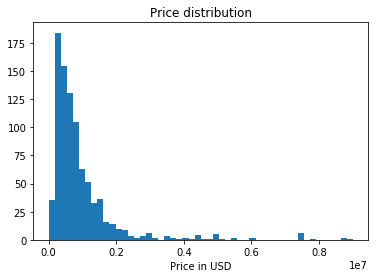

In [11]:
# Histogram
plt.hist(df.preciousd, bins=50)
plt.xlabel('Price in USD')
plt.title('Price distribution')

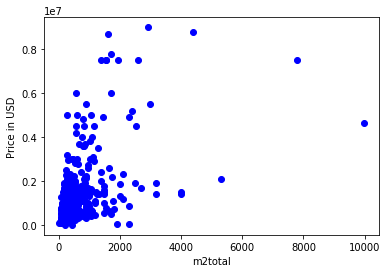

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [12]:
# Let’s visualize how prices are related with the total area:
# Scatter Plot
plt.scatter(df.m2total, df.preciousd,  color='blue')
plt.xlabel("m2total")
plt.ylabel("Price in USD")
plt.show()
sns.despine

## Simple Regression

In [13]:
# Creating train and test dataset
X = df[['m2total']]
y = df[['preciousd']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
# Modeling
lr = LinearRegression()
lr.fit(X_train, y_train)
# The coefficients
print ('Coefficients: ', lr.coef_)
print ('Intercept: ', lr.intercept_)

Coefficients:  [[943.32631249]]
Intercept:  [473528.46071088]


In [15]:
# Evaluation
y_pred = lr.predict(X_test)
'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.85'

Text(0, 0.5, 'Price in USD')

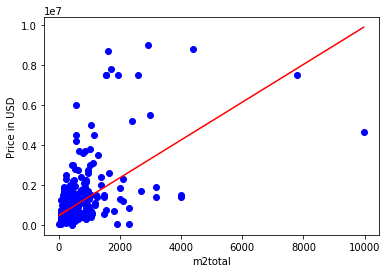

In [16]:
# Plot outputs
# we can plot the fit line over the data:
plt.scatter(X_train, y_train,  color='blue')
plt.plot(X_train, lr.coef_[0][0]*X_train+ lr.intercept_[0], '-r')
plt.xlabel("m2total")
plt.ylabel("Price in USD")

In [17]:
# Fitting in log-log
lr.fit(X_train.apply(np.log), y_train.apply(np.log))
y_pred = lr.predict(X_test.apply(np.log))
'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, np.exp(y_pred)))

'RMSLE: 0.80'

## Multi-linear Regression

### Improve the model using Foursquare data to create a multi-linear regression model

Search the number of venues near a piece of land. 

In [18]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'R4IHAX3SZWGI4FBGVPG0GWN3COMXJXBBYZSBEL04NA130FIO' # your Foursquare ID
CLIENT_SECRET = '5M21HY12HU5J4UH0AKW3NPEVY1KQLNL5LD4ZP4MQZ3LFBYF4' # your Foursquare Secret
VERSION = '20200605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R4IHAX3SZWGI4FBGVPG0GWN3COMXJXBBYZSBEL04NA130FIO
CLIENT_SECRET:5M21HY12HU5J4UH0AKW3NPEVY1KQLNL5LD4ZP4MQZ3LFBYF4


In [19]:
LIMIT = 1000
radius = 500

In [29]:
def venues_near(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['totalResults']
    
    return venues

In [30]:
df['venues_near'] = df.apply(lambda x: venues_near(x.lat, x.long), axis=1)

In [31]:
df.head()

,operacion,tipo,long,lat,m2total,direccion,calle,altura,cambio,preciotex,preciousd,precioars,preciousdm,precioarsm,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near
0,VTA,TERRENO,-58.414071,-34.618214,320.0,Agrelo 3399,Agrelo,3399.0,37.2,U$S 330000,330000.0,12276000.0,1031.250000,38362.500000,ALMAGRO,5.0,1224.0,C1224ABE,12
1,VTA,TERRENO,-58.424566,-34.610097,320.0,Bartolome Mitre y Gascon,Bartolome Mitre y Gascon,NaN,37.2,U$S 690000,690000.0,25668000.0,2156.250000,80212.500000,ALMAGRO,5.0,NaN,NaN,30
2,VTA,TERRENO,-58.424486,-34.613659,174.0,Don Bosco,Don Bosco,NaN,37.2,U$S 380000,380000.0,14136000.0,2183.908046,81241.379310,ALMAGRO,5.0,NaN,NaN,30
3,VTA,TERRENO,-58.423651,-34.614752,650.0,Hipolito Irigoyen 4043,Hipolito Irigoyen,4043.0,37.2,U$S 1000000,1000000.0,37200000.0,1538.461538,57230.769231,ALMAGRO,5.0,NaN,NaN,26
4,VTA,TERRENO,-58.413725,-34.603124,283.0,HUMAHUACA 3400,HUMAHUACA,3400.0,37.2,U$S 850000,850000.0,31620000.0,3003.533569,111731.448763,ALMAGRO,5.0,1191.0,C1191ABB,40


In [32]:
df[df['venues_near'].isna()]

,operacion,tipo,long,lat,m2total,direccion,calle,altura,cambio,preciotex,preciousd,precioars,preciousdm,precioarsm,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near


In [33]:
# Replace NANs values with 1
df['venues_near'].fillna(1, inplace=True)
df[df['venues_near'].isna()]

,operacion,tipo,long,lat,m2total,direccion,calle,altura,cambio,preciotex,preciousd,precioars,preciousdm,precioarsm,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near


In [34]:
# Creating train and test dataset
X = df[['m2total', 'venues_near']]
y = df[['preciousd']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
# Modeling
lr = LinearRegression()
lr.fit(X_train, y_train)
# The coefficients
print ('Coefficients: ', lr.coef_)
print ('Intercept: ', lr.intercept_)

Coefficients:  [[  930.14795281 13295.40442956]]
Intercept:  [149433.32091537]


In [36]:
# Evaluation
y_pred = lr.predict(X_test)
'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.75'

## Results

In [38]:
# Create dataframe of evaluation metrics
# initialise data of lists 
data = {'No Transform':['0.85', '0.80'], 'Log-Log':['0.75', '-']} 
# Creates pandas dataFrame 
df_metrics = pd.DataFrame(data, index =['Linear Regression (m2total)', 'Multi-linear Regression (m2total & venues)']) 

In [39]:
df_metrics

,No Transform,Log-Log
Linear Regression (m2total),0.85,0.75
Multi-linear Regression (m2total & venues),0.80,-
